In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from tqdm import tqdm

# Read the CSV file with a different encoding
df = pd.read_csv('/content/drive/MyDrive/Final_Robert/data.csv', names=["sentence", 'sentiment'], encoding='ISO-8859-1')

# Define the mapping for sentiment labels
sentiment_map = {
    'positive': 2,
    'negative': 0,
    'neutral': 1
}
df['sentiment'] = df['sentiment'].map(sentiment_map)

# Drop rows with NaN values in the 'sentiment' column
df = df.dropna(subset=['sentiment'])

# Apply the mapping to the 'sentiment' column in the DataFrame
df['sentiment'] = df['sentiment'].astype(int)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Final_Robert/data.csv'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

# Define your custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.loc[idx, 'sentence']
        label = self.dataframe.loc[idx, 'sentiment']
        encoding = self.tokenizer(text,
                                  add_special_tokens=True,
                                  max_length=self.max_len,
                                  truncation=True,
                                  padding='max_length',
                                  return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize the RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
num_classes = len(df['sentiment'].unique())  # Assuming labels are integers
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes)

# Define hyperparameters
batch_size = 16
max_len = 128
num_epochs = 3
learning_rate = 2e-5

# Create instances of custom dataset
dataset = CustomDataset(dataframe=df, tokenizer=tokenizer, max_len=max_len)

# Split dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# # Define training loop
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
#     for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batches'):
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)

#         optimizer.zero_grad()
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         total_loss += loss.item()
#         loss.backward()
#         optimizer.step()
#     avg_train_loss = total_loss / len(train_loader)
#     print(f'Average training loss: {avg_train_loss}')

#     # Validation
#     model.eval()
#     val_loss = 0
#     num_correct = 0
#     num_samples = 0
#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['labels'].to(device)

#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             val_loss += loss.item()

#             _, preds = torch.max(outputs.logits, dim=1)
#             num_correct += (preds == labels).sum().item()
#             num_samples += labels.size(0)

#     avg_val_loss = val_loss / len(val_loader)
#     val_accuracy = num_correct / num_samples
#     print(f'Average validation loss: {avg_val_loss}, Validation accuracy: {val_accuracy}')

#     # Update the learning rate
#     scheduler.step()

# print('Training complete!')
# # Save the model after training
# torch.save(model.state_dict(), 'roberta_model.pth')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
# # # Save the model after training
# torch.save(model.state_dict(), '/content/drive/MyDrive/Final_Robert/roberta_model.pth')

In [5]:

from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
num_classes = len(df['sentiment'].unique())  # Assuming labels are integers

model_path = '/content/drive/MyDrive/Final_Robert/roberta_model.pth'
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval()  # Set the model to evaluation mode

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [6]:
#new_sentence_pos="The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model ."
new_sentence_pos = "The company reported larger than expected earnings for the quarter, leading to a surge in stock prices."

new_sentence_neg = "The company reported lower than expected earnings for the quarter, leading to a drop in stock prices."
#new_sentence_neg = "$ESI on lows, down $1.50 to $2.50 BK a real possibility"

new_sentence_neut = "The company announced its quarterly earnings report."
#new_sentence_neut ="Ahlstrom Corporation STOCK EXCHANGE ANNOUNCEMENT 7.2.2007 at 10.30 A total of 56,955 new shares of Ahlstrom Corporation have been subscribed with option rights under the company 's stock option programs I 2001 and II 2001 ."

inputs = tokenizer(new_sentence_neg, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
print(predicted_label)


0


In [7]:
inputs = tokenizer(new_sentence_pos, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
print(predicted_label)

2


In [8]:
inputs = tokenizer(new_sentence_neut, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
print(predicted_label)

1


In [9]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer, pipeline

# Set up the few-shot pipeline
def create_few_shot_pipeline(model):
    # Load the fine-tuned RoBERTa model
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

    few_shot_pipeline = pipeline(
        task="text-classification",
        model=model,
        tokenizer=tokenizer
    )

    return few_shot_pipeline

# Define the path to your fine-tuned RoBERTa model (if applicable)
# model_path = "/content/drive/MyDrive/Final_RoBERTa"

# Instantiate the RoBERTa model for sequence classification

# Create the few-shot pipeline with your fine-tuned model
few_shot_pipeline = create_few_shot_pipeline(model)

# Define your few-shot texts and labels for training
few_shot_texts = [
    "The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .",
    "Ahlstrom Corporation STOCK EXCHANGE ANNOUNCEMENT 7.2.2007 at 10.30 A total of 56,955 new shares of Ahlstrom Corporation have been subscribed with option rights under the company 's stock option programs I 2001 and II 2001 .",
    "$ESI on lows, down $1.50 to $2.50 BK a real possibility"
]
few_shot_labels = ["Positive", "Neutral", "Negative"]  # Adjust labels accordingly

#
#########################################################
################ to  stop overfittinng ####################
############################################################
# for text, label in zip(few_shot_texts, few_shot_labels):
#     few_shot_pipeline(text)
#
#
#
#
# Ask the user for input and predict
user_input = input("Enter a statement: ")

result = few_shot_pipeline(user_input)

# Extract the predicted label from the result
predicted_label = result[0]['label']
predicted_score = result[0]['score']

print("Predicted label:", predicted_label)
print("Predicted score:", predicted_score)

# Map the internal label indices to the actual labels
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

# Get the predicted sentiment label
predicted_sentiment = label_map.get(predicted_label, "Unknown")
print("Predicted sentiment:", predicted_sentiment)


Enter a statement: its a profit business
Predicted label: LABEL_2
Predicted score: 0.6861215233802795
Predicted sentiment: Positive


In [ ]:
# # Define the path to save the model (including the filename with the .pth extension)
# save_model_path = "/content/drive/MyDrive/Final_Robert/fewshoted_model.pth"

# # Save the model's state_dict() to a .pth file
# torch.save(model.state_dict(), save_model_path)


In [11]:

from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
num_classes = len(df['sentiment'].unique())  # Assuming labels are integers

model_path = '/content/drive/MyDrive/Final_Robert/fewshoted_model.pth'
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval()  # Set the model to evaluation mode

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [12]:
import pandas as pd

# Define a list to store data
data = []

# Evaluate the model on the validation dataset and store data
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)  # Assuming labels are also tensors

        # Move model to the same device as input tensors
        model = model.to(device)

        # Make predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        # Append data to the list
        for i, label in enumerate(labels):  # Iterate over labels directly
            true_label = label.item()
            predicted_label = preds[i].item()
            data.append((true_label, predicted_label))

# Create a DataFrame
df_validation = pd.DataFrame(data, columns=['True Label', 'Predicted Label'])

# Display the DataFrame
print(df_validation)

# Save the DataFrame to a CSV file
df_validation.to_csv('your_file.csv', index=False)  # index=False prevents writing row indices


      True Label  Predicted Label
0              1                1
1              1                1
2              0                0
3              1                2
4              2                2
...          ...              ...
1164           2                2
1165           1                1
1166           0                0
1167           1                1
1168           0                0

[1169 rows x 2 columns]


In [13]:
import os

# Define the directory where you want to save the CSV file
save_directory = '/content/drive/MyDrive/Final_Robert'

# Ensure the directory exists, create it if necessary
os.makedirs(save_directory, exist_ok=True)

# Define the file path
csv_file_path = os.path.join(save_directory, 'your_file.csv')

# Save the DataFrame to a CSV file
df_validation.to_csv(csv_file_path, index=False)  # index=False prevents writing row indices

print(f"CSV file saved to: {csv_file_path}")


CSV file saved to: /content/drive/MyDrive/Final_Robert/your_file.csv


In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

# Assuming you have loaded your dataset into a pandas DataFrame
# Replace 'data.csv' with the path to your actual dataset
df = pd.read_csv(r"/content/drive/MyDrive/Final_Robert/your_file.csv")

# Extract true labels and predicted labels from the DataFrame
true_labels = df['True Label']
predicted_labels = df['Predicted Label']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("F1-score:", f1)




Accuracy: 0.8733960650128315
Precision: 0.8711965349979268
Recall: 0.8733960650128315
F1-score: 0.8721172974735661


In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix


# Extract true labels and predicted labels from the DataFrame
true_labels = df['True Label']
predicted_labels = df['Predicted Label']

# Get unique labels
labels = sorted(set(true_labels) | set(predicted_labels))

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=labels)

# Create a DataFrame for the confusion matrix with headers
confusion_df = pd.DataFrame(conf_matrix, index=['Actual ' + str(label) for label in labels], columns=['Predicted ' + str(label) for label in labels])
print("Confusion Matrix:")
print(confusion_df)


Confusion Matrix:
          Predicted 0  Predicted 1  Predicted 2
Actual 0          116           57            4
Actual 1           41          544           26
Actual 2            8           12          361


In [3]:
# Calculate the index for the positive class
positive_class_index = labels.index(2)

# Calculate true positives, false positives, false negatives for the positive class
tp_positive = conf_matrix[positive_class_index, positive_class_index]
fp_positive = conf_matrix[:, positive_class_index].sum() - tp_positive
fn_positive = conf_matrix[positive_class_index, :].sum() - tp_positive
tn_positive = conf_matrix.sum() - (tp_positive + fp_positive + fn_positive)

# Calculate precision, recall, and F1-score for the positive class
precision_positive = tp_positive / (tp_positive + fp_positive)
recall_positive = tp_positive / (tp_positive + fn_positive)
f1_positive = 2 * (precision_positive * recall_positive) / (precision_positive + recall_positive)
accuracy_positive = (tp_positive + tn_positive) / (tp_positive + tn_positive + fp_positive + fn_positive)

# Print the scores for the positive class
print("Accuracy for +ve class:", accuracy_positive)
print("Recall for +ve class:", recall_positive)
print("Precision for +ve class:", precision_positive)
print("F1-score for +ve class:", f1_positive)


Accuracy for +ve class: 0.9572284003421728
Recall for +ve class: 0.94750656167979
Precision for +ve class: 0.9232736572890026
F1-score for +ve class: 0.9352331606217616


In [17]:
# Calculate the index for the positive class (class 1)
positive_class_index = labels.index(1)

# Calculate true positives, false positives, false negatives for the positive class
tp_positive = conf_matrix[positive_class_index, positive_class_index]
fp_positive = conf_matrix[:, positive_class_index].sum() - tp_positive
fn_positive = conf_matrix[positive_class_index, :].sum() - tp_positive

# Calculate true negatives for the positive class (considering classes 0 and 2 as negative)
tn_positive = conf_matrix.sum() - (tp_positive + fp_positive + fn_positive)

# Calculate precision, recall, and F1-score for the positive class
precision_positive = tp_positive / (tp_positive + fp_positive)
recall_positive = tp_positive / (tp_positive + fn_positive)
f1_positive = 2 * (precision_positive * recall_positive) / (precision_positive + recall_positive)
accuracy_positive = (tp_positive + tn_positive) / (tp_positive + tn_positive + fp_positive + fn_positive)

# Print the scores for the positive class
print("Accuracy for neutral class (1):", accuracy_positive)
print("Recall for neutral class (1):", recall_positive)
print("Precision for neutral class (1):", precision_positive)
print("F1-score for neutral class (1):", f1_positive)


Accuracy for neutral class (1): 0.88366124893071
Recall for neutral class (1): 0.8903436988543372
Precision for neutral class (1): 0.8874388254486134
F1-score for neutral class (1): 0.8888888888888888


In [18]:
# Calculate the index for the positive class (class 0)
positive_class_index = labels.index(0)

# Calculate true positives, false positives, false negatives for the positive class
tp_positive = conf_matrix[positive_class_index, positive_class_index]
fp_positive = conf_matrix[:, positive_class_index].sum() - tp_positive
fn_positive = conf_matrix[positive_class_index, :].sum() - tp_positive

# Calculate true negatives for the positive class (considering classes 1 and 2 as negative)
tn_positive = conf_matrix.sum() - (tp_positive + fp_positive + fn_positive)

# Calculate precision, recall, and F1-score for the positive class
precision_positive = tp_positive / (tp_positive + fp_positive)
recall_positive = tp_positive / (tp_positive + fn_positive)
f1_positive = 2 * (precision_positive * recall_positive) / (precision_positive + recall_positive)
accuracy_positive = (tp_positive + tn_positive) / (tp_positive + tn_positive + fp_positive + fn_positive)

# Print the scores for the positive class
print("Accuracy for class :", accuracy_positive)
print("Recall for class :", recall_positive)
print("Precision for class :", precision_positive)
print("F1-score for class 0 :", f1_positive)


Accuracy for class : 0.9059024807527801
Recall for class : 0.655367231638418
Precision for class : 0.703030303030303
F1-score for class 0 : 0.6783625730994153


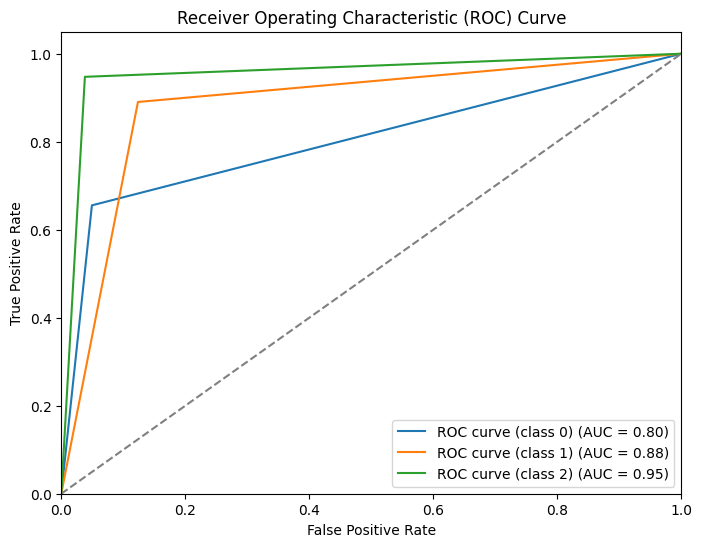

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute the ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predicted_labels == i)
    roc_auc[i] = roc_auc_score(true_labels == i, predicted_labels == i)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



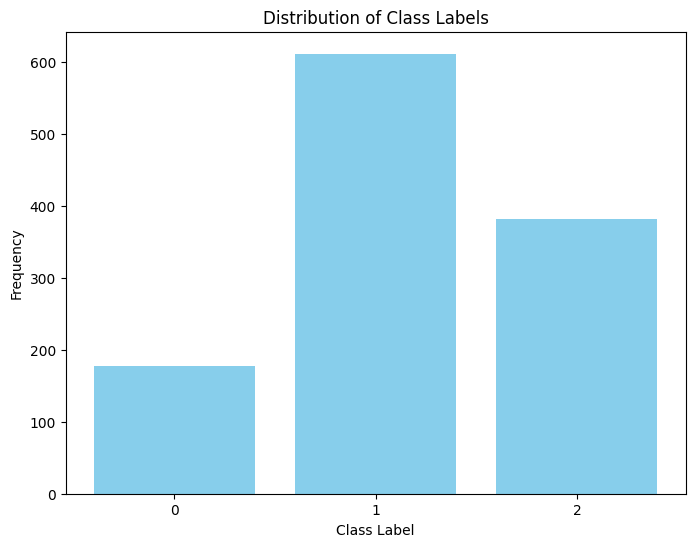

In [20]:
import matplotlib.pyplot as plt

# Count the frequency of each class label
label_counts = df['True Label'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Class Labels')
plt.xticks(label_counts.index)  # Ensure all class labels are shown on the x-axis
plt.show()


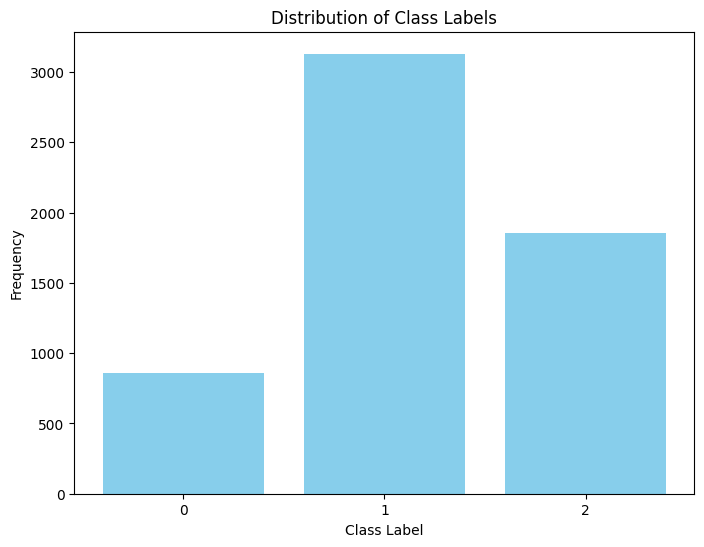

In [21]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Read the CSV file with a different encoding
dff = pd.read_csv(r"/content/drive/MyDrive/Final_Robert/data.csv", names=["sentence", 'sentiment'], encoding='ISO-8859-1')

# Define the mapping for sentiment labels
sentiment_map = {
    'positive': 2,
    'negative': 0,
    'neutral': 1
}
dff['sentiment'] = dff['sentiment'].map(sentiment_map)

# Drop rows with NaN values in the 'sentiment' column
dff = dff.dropna(subset=['sentiment'])

# Apply the mapping to the 'sentiment' column in the DataFrame
dff['sentiment'] = dff['sentiment'].astype(int)


label_counts = dff['sentiment'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Class Labels')
plt.xticks(label_counts.index)  # Ensure all class labels are shown on the x-axis
plt.show()
